# Day 6 — Evaluation & Analysis (Feature analysis, cosine similarity, baseline comparison)

**Author:** ALEXANDER WAMBUGU  
**Repo branch:** `alex`

This notebook:
- Loads TF-IDF / BoW / ngram matrices and vectorizers saved in `feature_engineering_output/`
- Produces feature analysis (most informative words for positive/negative classes)
- Computes cosine similarity between top words
- Compares available models (if present) to the majority-class baseline
- Produces CSVs and figures under `/analysis_results/` and `/figs/`


In [1]:
import os
os.getcwd()


'C:\\Users\\wambu\\OneDrive\\Documents\\Sentiment-Analysis'

In [5]:
import os

os.listdir("feature_engineering_output")


['bow_vectorizer.pkl',
 'bow_vocabulary.txt',
 'bow_X_test.npz',
 'bow_X_train.npz',
 'ngram_vectorizer.pkl',
 'ngram_vocabulary.txt',
 'ngram_X_test.npz',
 'ngram_X_train.npz',
 'test_data.csv',
 'tfidf_vectorizer.pkl',
 'tfidf_vocabulary.txt',
 'tfidf_X_test.npz',
 'tfidf_X_train.npz',
 'train_data.csv',
 'y_test.npy',
 'y_train.npy']

In [9]:
# Cell: imports and paths
import os, sys, joblib, pickle
import numpy as np
import pandas as pd
import scipy.sparse as sp
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Paths (adjust if your repo uses different names/locations)
ROOT = os.getcwd()        # repo root - ensure notebook is started from repo root
FE_OUT = os.path.join(ROOT, "feature_engineering_output")
DATA_ROOT = ROOT          # IMDB Dataset.csv is in repo root per your message
ANALYSIS_DIR = os.path.join(ROOT, "analysis_results")
FIGS_DIR = os.path.join(ROOT, "figs")
os.makedirs(ANALYSIS_DIR, exist_ok=True)
os.makedirs(FIGS_DIR, exist_ok=True)

print("feature_engineering_output exists:", os.path.isdir(FE_OUT))
print("Files in feature_engineering_output (sample):")
for f in sorted(os.listdir(FE_OUT))[:40]:
    print(" ", f)


feature_engineering_output exists: True
Files in feature_engineering_output (sample):
  bow_X_test.npz
  bow_X_train.npz
  bow_vectorizer.pkl
  bow_vocabulary.txt
  ngram_X_test.npz
  ngram_X_train.npz
  ngram_vectorizer.pkl
  ngram_vocabulary.txt
  test_data.csv
  tfidf_X_test.npz
  tfidf_X_train.npz
  tfidf_vectorizer.pkl
  tfidf_vocabulary.txt
  train_data.csv
  y_test.npy
  y_train.npy


In [11]:
# Load TF-IDF and other matrices (safe-loading with checks)
def load_npz_safe(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    return sp.load_npz(path).tocsr()

# Files we expect (based on your list)
expected_files = {
    "tfidf_X_train": os.path.join(FE_OUT, "tfidf_X_train.npz"),
    "tfidf_X_test":  os.path.join(FE_OUT, "tfidf_X_test.npz"),
    "bow_X_train":   os.path.join(FE_OUT, "bow_X_train.npz"),
    "bow_X_test":    os.path.join(FE_OUT, "bow_X_test.npz"),
    "ngram_X_train": os.path.join(FE_OUT, "ngram_X_train.npz"),
    "ngram_X_test":  os.path.join(FE_OUT, "ngram_X_test.npz"),
    "y_train":       os.path.join(FE_OUT, "y_train.npy"),
    "y_test":        os.path.join(FE_OUT, "y_test.npy"),
    "tfidf_vect":    os.path.join(FE_OUT, "tfidf_vectorizer.pkl"),
    "bow_vect":      os.path.join(FE_OUT, "bow_vectorizer.pkl"),
    "ngram_vect":    os.path.join(FE_OUT, "ngram_vectorizer.pkl"),
    "tfidf_vocab":   os.path.join(FE_OUT, "tfidf_vocabulary.txt"),
    "test_split":    os.path.join(ROOT, "test_split.csv"),
    "train_split":   os.path.join(ROOT, "train_split.csv"),
}

# quick existence report
for k,p in expected_files.items():
    print(k, "->", os.path.exists(p), ":", p)


tfidf_X_train -> True : C:\Users\wambu\OneDrive\Documents\Sentiment-Analysis\feature_engineering_output\tfidf_X_train.npz
tfidf_X_test -> True : C:\Users\wambu\OneDrive\Documents\Sentiment-Analysis\feature_engineering_output\tfidf_X_test.npz
bow_X_train -> True : C:\Users\wambu\OneDrive\Documents\Sentiment-Analysis\feature_engineering_output\bow_X_train.npz
bow_X_test -> True : C:\Users\wambu\OneDrive\Documents\Sentiment-Analysis\feature_engineering_output\bow_X_test.npz
ngram_X_train -> True : C:\Users\wambu\OneDrive\Documents\Sentiment-Analysis\feature_engineering_output\ngram_X_train.npz
ngram_X_test -> True : C:\Users\wambu\OneDrive\Documents\Sentiment-Analysis\feature_engineering_output\ngram_X_test.npz
y_train -> True : C:\Users\wambu\OneDrive\Documents\Sentiment-Analysis\feature_engineering_output\y_train.npy
y_test -> True : C:\Users\wambu\OneDrive\Documents\Sentiment-Analysis\feature_engineering_output\y_test.npy
tfidf_vect -> True : C:\Users\wambu\OneDrive\Documents\Sentiment

In [13]:
# Load TF-IDF train/test and labels
X_tfidf_train = load_npz_safe(expected_files["tfidf_X_train"])
X_tfidf_test  = load_npz_safe(expected_files["tfidf_X_test"])
y_train = np.load(expected_files["y_train"])
y_test  = np.load(expected_files["y_test"])
print("X_tfidf_train.shape:", X_tfidf_train.shape)
print("X_tfidf_test.shape:", X_tfidf_test.shape)
print("y_train.shape:", y_train.shape, "counts:", Counter(y_train))


X_tfidf_train.shape: (40000, 5000)
X_tfidf_test.shape: (10000, 5000)
y_train.shape: (40000,) counts: Counter({1: 20000, 0: 20000})


In [15]:
# try loading vectorizer to get readable feature names
feature_names = None
tfidf_vect_path = expected_files["tfidf_vect"]
if os.path.exists(tfidf_vect_path):
    tfidf_vect = joblib.load(tfidf_vect_path)
    try:
        feature_names = list(tfidf_vect.get_feature_names_out())
    except Exception:
        try:
            feature_names = list(tfidf_vect.get_feature_names())
        except Exception:
            feature_names = None

# if we don't have a pickled vectorizer, try reading vocabulary txt
if feature_names is None and os.path.exists(expected_files["tfidf_vocab"]):
    with open(expected_files["tfidf_vocab"], "r", encoding="utf-8", errors="ignore") as fh:
        lines = [ln.strip() for ln in fh if ln.strip()]
    # if file is "token index" try to parse; else assume 1 token per line
    if all(len(ln.split())==2 and ln.split()[1].isdigit() for ln in lines[:50]):
        # parse "token index"
        tmp = {}
        for ln in lines:
            parts = ln.split()
            token = " ".join(parts[:-1])
            idx = int(parts[-1])
            tmp[idx] = token
        maxidx = max(tmp.keys())
        feature_names = [tmp.get(i, f"f{i}") for i in range(maxidx+1)]
    else:
        feature_names = lines

# final fallback: generic names
if feature_names is None:
    feature_names = [f"f{i}" for i in range(X_tfidf_train.shape[1])]

print("Number of features:", len(feature_names))
assert len(feature_names) == X_tfidf_train.shape[1], "Feature count mismatch! Check vectorizer/vocab."


Number of features: 5000


C:\Users\public\anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\public\anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [17]:
# attempt to load classifier files if your group saved them under /models/
models_dir = os.path.join(ROOT, "models")
available_models = {}
if os.path.isdir(models_dir):
    for fn in sorted(os.listdir(models_dir)):
        if fn.endswith(('.pkl', '.joblib', '.sav')):
            path = os.path.join(models_dir, fn)
            try:
                obj = joblib.load(path)
                available_models[fn] = obj
                print("Loaded model:", fn, "type", type(obj))
            except Exception as e:
                print("Failed to load model", fn, ":", e)
else:
    print("No /models/ directory found (optional).")


No /models/ directory found (optional).


In [19]:
# Evaluate baseline on y_test using majority label from train
maj = Counter(y_train).most_common(1)[0][0]
y_baseline = np.full_like(y_test, fill_value=maj)
baseline_acc = accuracy_score(y_test, y_baseline)
baseline_prec = precision_score(y_test, y_baseline, average='binary', zero_division=0)
baseline_rec = recall_score(y_test, y_baseline, average='binary', zero_division=0)
baseline_f1 = f1_score(y_test, y_baseline, average='binary', zero_division=0)
print("Majority baseline: label", maj, "acc {:.4f} prec {:.4f} rec {:.4f} f1 {:.4f}".format(
    baseline_acc, baseline_prec, baseline_rec, baseline_f1))
# Save baseline
pd.DataFrame([{"model":"majority_baseline","accuracy":baseline_acc,"precision":baseline_prec,"recall":baseline_rec,"f1":baseline_f1}]).to_csv(os.path.join(ANALYSIS_DIR,"model_evaluation_summary.csv"),index=False)


Majority baseline: label 1 acc 0.5000 prec 0.5000 rec 1.0000 f1 0.6667


In [21]:
def top_features_from_logistic(model, feature_names, topn=30):
    coef = model.coef_.ravel()
    pos_idx = np.argsort(coef)[-topn:][::-1]
    neg_idx = np.argsort(coef)[:topn]
    return pd.DataFrame({
        "pos_word": [feature_names[i] for i in pos_idx],
        "pos_coef": coef[pos_idx],
        "neg_word": [feature_names[i] for i in neg_idx],
        "neg_coef": coef[neg_idx],
    })

def top_features_from_nb(model, feature_names, topn=30):
    flp = model.feature_log_prob_
    diff = flp[1] - flp[0] if flp.shape[0] >= 2 else flp[0]
    pos_idx = np.argsort(diff)[-topn:][::-1]
    neg_idx = np.argsort(diff)[:topn]
    return pd.DataFrame({
        "pos_word": [feature_names[i] for i in pos_idx],
        "pos_score": diff[pos_idx],
        "neg_word": [feature_names[i] for i in neg_idx],
        "neg_score": diff[neg_idx],
    })

# try model-based first
feature_tables = {}
for name, model in available_models.items():
    low = type(model).__name__.lower()
    try:
        if hasattr(model, "coef_"):
            feature_tables[name] = top_features_from_logistic(model, feature_names, topn=50)
            print("Extracted logistic features from", name)
        elif hasattr(model, "feature_log_prob_"):
            feature_tables[name] = top_features_from_nb(model, feature_names, topn=50)
            print("Extracted NB features from", name)
    except Exception as e:
        print("Failed to extract features for", name, ":", e)

# fallback if no model tables produced
if not feature_tables:
    print("No coefficient-based model features available -> computing TF-IDF mean difference")
    pos_mask = (y_train==1)
    neg_mask = (y_train==0)
    mean_pos = np.asarray(X_tfidf_train[pos_mask,:].mean(axis=0)).ravel()
    mean_neg = np.asarray(X_tfidf_train[neg_mask,:].mean(axis=0)).ravel()
    diff = mean_pos - mean_neg
    top_pos_idx = np.argsort(diff)[-50:][::-1]
    top_neg_idx = np.argsort(diff)[:50]
    df = pd.DataFrame({
        "pos_word": [feature_names[i] for i in top_pos_idx],
        "pos_mean_diff": diff[top_pos_idx],
        "neg_word": [feature_names[i] for i in top_neg_idx],
        "neg_mean_diff": diff[top_neg_idx],
    })
    feature_tables["tfidf_mean_diff"] = df
    df.to_csv(os.path.join(ANALYSIS_DIR, "top_features_tfidf_mean_diff.csv"), index=False)
    display(df.head(30))
else:
    # save all model feature tables
    for nm, df in feature_tables.items():
        df.to_csv(os.path.join(ANALYSIS_DIR, f"top_features_{nm}.csv"), index=False)
        display(df.head(30))


No coefficient-based model features available -> computing TF-IDF mean difference


,pos_word,pos_mean_diff,neg_word,neg_mean_diff
0,great,0.017239,bad,-0.024708
1,love,0.010625,movie,-0.015577
2,best,0.009917,worst,-0.015023
3,excellent,0.008799,waste,-0.010468
4,wonderful,0.007305,awful,-0.009700
5,life,0.007136,terrible,-0.009185
6,performance,0.006783,plot,-0.008614
7,loved,0.006070,minute,-0.008097
8,perfect,0.005663,stupid,-0.008093
9,beautiful,0.005602,boring,-0.007937


In [23]:
# choose source (prefer model-based name else tfidf_mean_diff)
source = list(feature_tables.keys())[0]
df_top = feature_tables[source]
# take top 20 pos + top 20 neg
top_pos = df_top["pos_word"].tolist()[:20]
top_neg = df_top["neg_word"].tolist()[:20]
top_words = list(dict.fromkeys(top_pos + top_neg))
print("num top_words:", len(top_words))

# map to indices and build word vectors (columns are words)
word2idx = {w:i for i,w in enumerate(feature_names)}
cols = [word2idx[w] for w in top_words if w in word2idx]
present_words = [w for w in top_words if w in word2idx]
missing = [w for w in top_words if w not in word2idx]
print("present:", len(present_words), "missing:", missing[:10])

W = X_tfidf_train[:, cols].toarray().T  # shape (n_words, n_docs)
cos_mat = cosine_similarity(W)
cos_df = pd.DataFrame(cos_mat, index=present_words, columns=present_words)
cos_df.to_csv(os.path.join(ANALYSIS_DIR, "cosine_similarity_top_words.csv"))
display(cos_df.round(4).iloc[:10,:10])
print("Saved cosine similarity CSV to", os.path.join(ANALYSIS_DIR, "cosine_similarity_top_words.csv"))


num top_words: 40
present: 40 missing: []


,great,love,best,excellent,wonderful,life,performance,loved,perfect,beautiful
great,1.0000,0.1875,0.2147,0.1424,0.1451,0.1536,0.1872,0.1496,0.1195,0.1352
love,0.1875,1.0000,0.1577,0.0842,0.1293,0.1913,0.1197,0.1517,0.1122,0.1482
best,0.2147,0.1577,1.0000,0.1406,0.1079,0.1490,0.1871,0.0842,0.1124,0.0972
excellent,0.1424,0.0842,0.1406,1.0000,0.0789,0.0944,0.1596,0.0637,0.0723,0.0799
wonderful,0.1451,0.1293,0.1079,0.0789,1.0000,0.1017,0.1150,0.0752,0.0791,0.1082
life,0.1536,0.1913,0.1490,0.0944,0.1017,1.0000,0.1252,0.0801,0.0924,0.1281
performance,0.1872,0.1197,0.1871,0.1596,0.1150,0.1252,1.0000,0.0620,0.0897,0.0941
loved,0.1496,0.1517,0.0842,0.0637,0.0752,0.0801,0.0620,1.0000,0.0691,0.0676
perfect,0.1195,0.1122,0.1124,0.0723,0.0791,0.0924,0.0897,0.0691,1.0000,0.0807
beautiful,0.1352,0.1482,0.0972,0.0799,0.1082,0.1281,0.0941,0.0676,0.0807,1.0000


Saved cosine similarity CSV to C:\Users\wambu\OneDrive\Documents\Sentiment-Analysis\analysis_results\cosine_similarity_top_words.csv


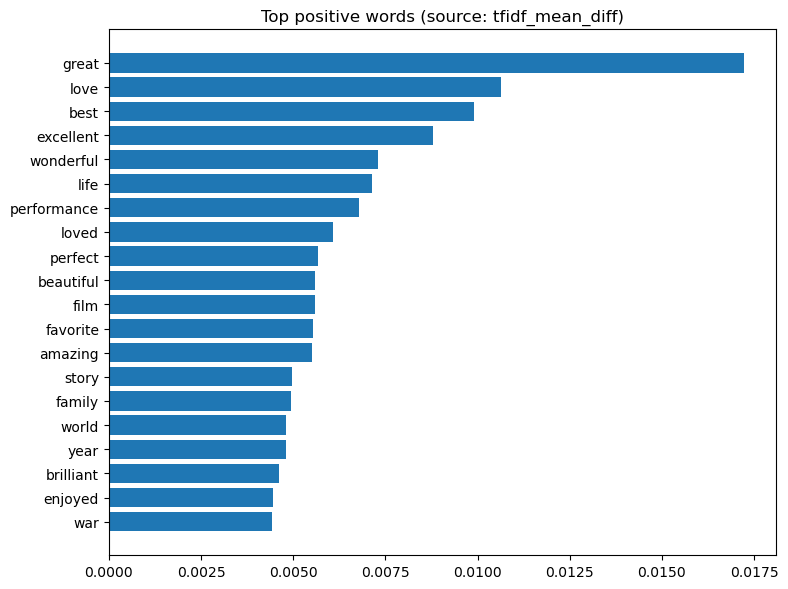

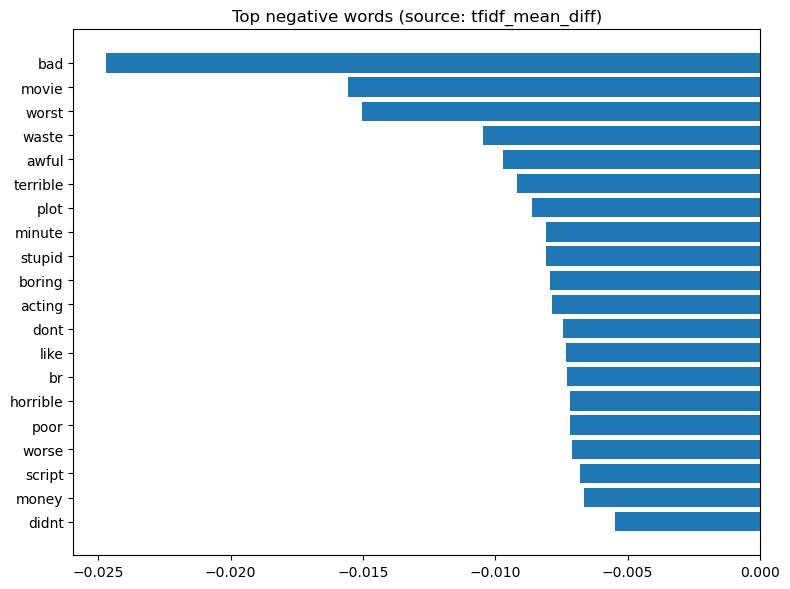

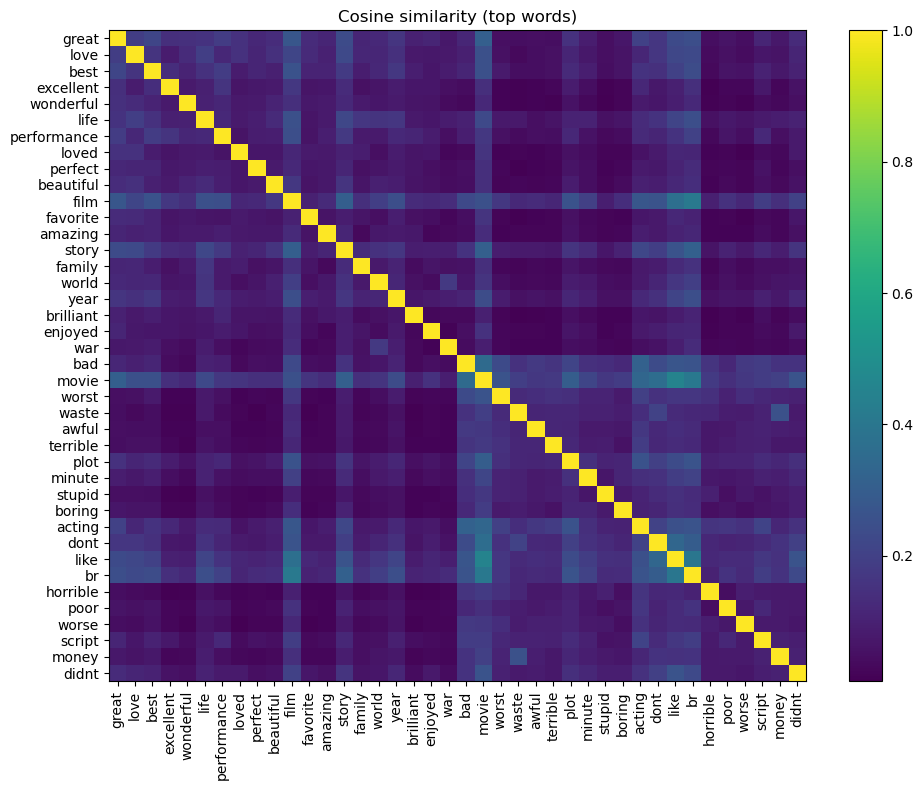

Saved figs to C:\Users\wambu\OneDrive\Documents\Sentiment-Analysis\figs


In [25]:
# Bar chart for top positive words (showing score)
topn_plot = 20
if "pos_coef" in df_top.columns:
    vals = df_top["pos_coef"].tolist()[:topn_plot]
elif "pos_mean_diff" in df_top.columns:
    vals = df_top["pos_mean_diff"].tolist()[:topn_plot]
else:
    vals = [0]*topn_plot

labels = df_top["pos_word"].tolist()[:topn_plot][::-1]
vals_plot = vals[:topn_plot][::-1]

plt.figure(figsize=(8,6))
plt.barh(range(len(vals_plot)), vals_plot)
plt.yticks(range(len(vals_plot)), labels)
plt.title("Top positive words (source: {})".format(source))
plt.tight_layout(); plt.savefig(os.path.join(FIGS_DIR,"top_words_pos_bar.png")); plt.show()

# Negative words
if "neg_coef" in df_top.columns:
    valsn = df_top["neg_coef"].tolist()[:topn_plot]
elif "neg_mean_diff" in df_top.columns:
    valsn = df_top["neg_mean_diff"].tolist()[:topn_plot]
else:
    valsn = [0]*topn_plot

labelsn = df_top["neg_word"].tolist()[:topn_plot][::-1]
valsn_plot = valsn[:topn_plot][::-1]
plt.figure(figsize=(8,6))
plt.barh(range(len(valsn_plot)), valsn_plot)
plt.yticks(range(len(valsn_plot)), labelsn)
plt.title("Top negative words (source: {})".format(source))
plt.tight_layout(); plt.savefig(os.path.join(FIGS_DIR,"top_words_neg_bar.png")); plt.show()

# Heatmap for cosine similarity (top 40 words)
import numpy as np
plt.figure(figsize=(10,8))
v = cos_df.values
plt.imshow(v, aspect='auto')
plt.colorbar()
plt.xticks(range(len(cos_df.columns)), cos_df.columns, rotation=90)
plt.yticks(range(len(cos_df.index)), cos_df.index)
plt.title("Cosine similarity (top words)")
plt.tight_layout(); plt.savefig(os.path.join(FIGS_DIR,"cosine_heatmap.png")); plt.show()
print("Saved figs to", FIGS_DIR)


In [27]:
# Optional: map test rows to original raw text for error analysis
imdb_path = os.path.join(ROOT, "IMDB Dataset.csv")
if os.path.exists(imdb_path):
    df_raw = pd.read_csv(imdb_path)
    # Attempt to find test indices mapping
    test_split_path = expected_files["test_split"]
    if os.path.exists(test_split_path):
        test_mapping = pd.read_csv(test_split_path)   # expected to contain column 'index' or original row ids
        print("test_split columns:", test_mapping.columns.tolist())
        # Assume there's a column 'original_index' or 'index' we can use:
        idx_col = None
        for c in ["index","original_index","orig_index","row_id","id"]:
            if c in test_mapping.columns:
                idx_col = c; break
        if idx_col is None:
            print("No index col found in test_split.csv; cannot map to raw text automatically.")
        else:
            test_indices = test_mapping[idx_col].values
            # Evaluate using a specific model (choose one that predicted earlier)
            if available_models:
                name, model = next(iter(available_models.items()))
                try:
                    y_pred = model.predict(X_tfidf_test)
                except Exception:
                    y_pred = model.predict(X_tfidf_test.toarray())
                # find false positives and false negatives
                fp_mask = (y_test==0) & (y_pred==1)
                fn_mask = (y_test==1) & (y_pred==0)
                fp_rows = np.where(fp_mask)[0]
                fn_rows = np.where(fn_mask)[0]
                # map first 50 examples
                fp_orig_idx = test_indices[fp_rows][:50]
                fn_orig_idx = test_indices[fn_rows][:50]
                df_raw.loc[fp_orig_idx, ["review"]].head(20).to_csv(os.path.join(ANALYSIS_DIR,"false_pos_examples.csv"), index=False)
                df_raw.loc[fn_orig_idx, ["review"]].head(20).to_csv(os.path.join(ANALYSIS_DIR,"false_neg_examples.csv"), index=False)
                print("Saved false_pos_examples.csv and false_neg_examples.csv to", ANALYSIS_DIR)
            else:
                print("No loaded models to compute false positive/negative examples.")
    else:
        print("No test_split.csv found to map to raw text. You can produce test indices at split time and save them for later mapping.")
else:
    print("IMDB Dataset.csv not found in repo root; cannot map raw text.")


test_split columns: ['text', 'sentiment']
No index col found in test_split.csv; cannot map to raw text automatically.


In [29]:
print("All done. Files produced in:", ANALYSIS_DIR, "and", FIGS_DIR)
print("- model_evaluation_summary.csv (baseline + any evaluated models)")
print("- top_features_*.csv  (top feature lists)")
print("- cosine_similarity_top_words.csv")
print("- false_pos_examples.csv, false_neg_examples.csv  (if mapped)")
print("- figures in", FIGS_DIR)


All done. Files produced in: C:\Users\wambu\OneDrive\Documents\Sentiment-Analysis\analysis_results and C:\Users\wambu\OneDrive\Documents\Sentiment-Analysis\figs
- model_evaluation_summary.csv (baseline + any evaluated models)
- top_features_*.csv  (top feature lists)
- cosine_similarity_top_words.csv
- false_pos_examples.csv, false_neg_examples.csv  (if mapped)
- figures in C:\Users\wambu\OneDrive\Documents\Sentiment-Analysis\figs
